# Exploratory Data Analysis

- 데이터 전처리
    - 데이터 탐색
    - 데이터 클렌징

In [1]:
%matplotlib inline
pd.options.display.max_columns = 200
from numpy.linalg import svd
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_action = pd.read_csv('../input/제6회 L.POINT Big Data Competition-분석용데이터-01.온라인 행동 정보.csv')
df_transaction = pd.read_csv('../input/제6회 L.POINT Big Data Competition-분석용데이터-02.거래 정보.csv')
df_client_demo = pd.read_csv('../input/제6회 L.POINT Big Data Competition-분석용데이터-03.고객 Demographic 정보.csv')
df_product = pd.read_csv('../input/제6회 L.POINT Big Data Competition-분석용데이터-04.상품분류 정보.csv')

# Online Action columns
- clnt_id : 클라이언트 ID, 고객을 고유하게 식별할 수 있도록 랜덤으로 부여된 ID
- sess_id : 세션 ID, Web/App에 접속 후 세션이 시작될 때 부여된 순번 ID (클라이언트 ID에 여러개의 세션 ID 발급될 수 있음)
- hit_seq : 조회일련번호, 조회 순서를 알 수 있도록 부여된 일련번호
- action_type : 행동유형, 총 8가지의 행동 유형을 구분한 코드 [0.검색/ 1.제품 목록/ 2.제품 세부정보 보기/ 3. 장바구니 제품 추가/ 4, 장바구니 제품 삭제/ 5. 결제시도/ 6. 구매 완료/ 7. 구매환불/ 8. 결제옵션]
- biz_unit : 업종단위, 온라인 및 오프라인 이용처를 구분하는 단위코드
- sess_dt : 세션일자, (YYYYMMDD 형식)
- hit_tm : 조회시간 (HH:MM 형식)
- hit_pss_tm : 조회경과시간, 세션이 시작된 이후 해당 조회까지 경과한 시간(단위:밀리초), 첫번째 조회하면 0으로 설정
- trans_id : 거래 ID, 구매내역을 고유하게 식별할 수 있도록 랜덤으로 부여된 ID
- srch_kwd : 검색 키워드, 고객이 검색한 키워드
- tot_pag_view_ct : 홈페이지조회건수, 세션 내의 총 페이지(화면)뷰 수
- tot_sess_hr_v : 총세션시간값, 세션 내 총 시간(단위: 초)
- trfc_src : 유입채널, 고객이 유입된 채널, [DIRECT/ PUSH/ WEBSITE/ PORTAL_1/ PORTAL_2/ PORTAL_3/ unknown]
- dvc_ctg_nm : 기기유형, [mobile_web/ mobile_app/ PC]

In [3]:
df_action.tail(10)

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
3196352,31032,3,5,0,A02,20190805,10:54,47963,NaN,오야니,8.0,356.0,unknown,mobile_app
3196353,31032,2,6,0,A02,20190804,22:37,527684,NaN,오야니,19.0,1047.0,unknown,mobile_app
3196354,31032,2,9,0,A02,20190804,22:41,771472,NaN,오야니,19.0,1047.0,unknown,mobile_app
3196355,31032,2,1,0,A02,20190804,22:35,356864,NaN,양가죽자켓,19.0,1047.0,unknown,mobile_app
3196356,31032,3,1,0,A02,20190805,10:53,8782,NaN,오야니,8.0,356.0,unknown,mobile_app
3196357,31040,1,1,0,A02,20190815,03:47,13525,NaN,다이슨 에어랩,4.0,62.0,unknown,mobile_web
3196358,4129,1,2,0,A02,20190721,01:22,250099,NaN,여성메탈시계,3.0,250.0,unknown,mobile_web
3196359,4129,1,1,0,A02,20190721,01:18,1525,NaN,여성메탈시계,3.0,250.0,unknown,mobile_web
3196360,54403,3,1,0,A02,20190731,20:14,16905,NaN,비비고왕교자,3.0,68.0,unknown,mobile_app
3196361,54403,4,1,0,A02,20190818,16:35,82700,NaN,에포테쉬볼륨팝브러쉬,5.0,101.0,unknown,mobile_app


### Missing Data

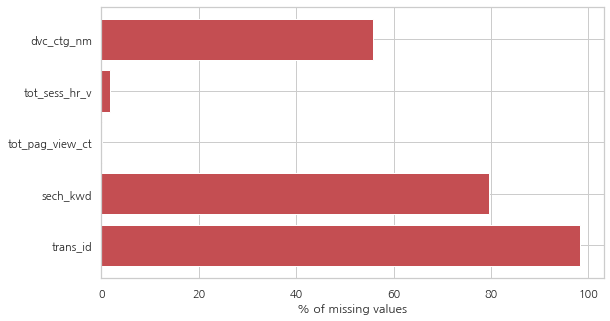

In [4]:
df_missing = df_action.isnull().sum(axis=0).reset_index()
df_missing.columns = ['column_name', 'missing_count']
df_missing = df_missing.loc[df_missing['missing_count']>0]
ind = np.arange(df_missing.shape[0])
fig, ax = plt.subplots(figsize=(9,5))
rects = ax.barh(ind, (df_missing.missing_count.values/len(df_action))*100, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(df_missing.column_name.values, rotation='horizontal')
ax.set_xlabel("% of missing values")
plt.show()

# Transaction columns
- clnt_id : 클라이언트 ID 
- trans_id : 거래 ID
- trans_seq: 거래일련번호, 해당 거래 ID의 구매 내역 내 구매 순서를 알 수 있도록 부여된 일련번호
- biz_unit : 업종단위  
- pd_c : 상품소분류코드,
- de_dt : 상품을 구매한 일자 (YYYYMMDD)
- de_tm : 상품을 구매한 시각 (HH:MM)
- buy_am : 구매한 상품의 금액
- buy_ct : 구매한 상품의 수량

In [5]:
df_transaction.tail(10)

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct
599951,2400,4453,2,B03,0313,20190927,11:25,7700,1
599952,28484,13342,1,B03,1060,20190927,15:47,5000,1
599953,54080,2842,2,B03,0339,20190927,16:16,5200,1
599954,54080,2842,1,B03,1066,20190927,16:16,12600,1
599955,35311,2839,1,B03,0339,20190927,14:09,4500,1
599956,35311,2839,3,B03,0339,20190927,14:09,3500,1
599957,35311,2839,4,B03,0339,20190927,14:09,3600,2
599958,35311,2839,5,B03,0339,20190927,14:09,3500,1
599959,35311,2839,2,B03,0339,20190927,14:09,4500,1
599960,35311,2839,6,B03,0324,20190927,14:09,6800,1


# Client Demographic
- clnt_id : 클라이언트 ID
- clnt_gender : 성별 [M/F/unknown]
- clnt_age : 연령대 [10대 이하/ 20대/ 30대/ 40대/ 50대/ 60대 이상/ 정보없음 : unknown]

In [6]:
df_client_demo.tail(10)

,clnt_id,clnt_gender,clnt_age
72389,72420,unknown,unknown
72390,72421,unknown,unknown
72391,72422,unknown,unknown
72392,72423,F,30
72393,72424,M,40
72394,72425,unknown,unknown
72395,72426,unknown,unknown
72396,72427,unknown,unknown
72397,72428,unknown,unknown
72398,72429,unknown,unknown


# Product columns
- pd_c : 상품 소분류코드 (최소단위)
- clac_nm1 : 상품 대분류명
- clac_nm2 : 상품 중분류명
- clac_nm3 : 상품 소분류명

In [7]:
df_product.tail(10)

,pd_c,clac_nm1,clac_nm2,clac_nm3
1657,1658,Women's Clothing,Women's Special Use Clothing,Other Women's Special Use Clothing
1658,1659,Women's Clothing,Women's Special Use Clothing,Women's Costumes
1659,1660,Women's Clothing,Women's Special Use Clothing,Women's Fashion Trainingwear
1660,1661,Women's Clothing,Women's Upper Bodywear / Tops,Women's Blouses
1661,1662,Women's Clothing,Women's Upper Bodywear / Tops,Women's Button-Down Shirts
1662,1663,Women's Clothing,Women's Upper Bodywear / Tops,Women's Cardigans
1663,1664,Women's Clothing,Women's Upper Bodywear / Tops,Women's Sweaters / Pullover
1664,1665,Women's Clothing,Women's Upper Bodywear / Tops,Women's Sweatshirts / Hoodies
1665,1666,Women's Clothing,Women's Upper Bodywear / Tops,Women's T-shirts / Tops
1666,1667,Women's Clothing,Women's Upper Bodywear / Tops,Women's Vests


### Missing Data

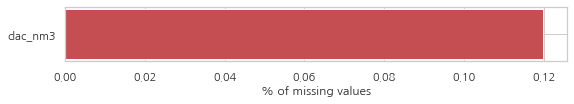

In [8]:
df_missing = df_product.isnull().sum(axis=0).reset_index()
df_missing.columns = ['column_name', 'missing_count']
df_missing = df_missing.loc[df_missing['missing_count']>0]
ind = np.arange(df_missing.shape[0])
fig, ax = plt.subplots(figsize=(9,1))
rects = ax.barh(ind, (df_missing.missing_count.values/len(df_product))*100, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(df_missing.column_name.values, rotation='horizontal')
ax.set_xlabel("% of missing values")
plt.show()

In [9]:
df1 = df_transaction[['clnt_id', 'pd_c']]
df1.loc[df1['pd_c'] == 'unknown', 'pd_c'] = '0000'
df1['clnt_id'] = df1['clnt_id'].astype(int)
df1['pd_c'] = df1['pd_c'].astype(int)
df = pd.merge(df1, df_product, how='left')
df2 = df[['clnt_id', 'clac_nm3']]
df3 = df2.groupby(["clnt_id", "clac_nm3"]).size().reset_index(name="Counts")
df3.tail(2)

,clnt_id,clac_nm3,Counts
327502,72424,Women's Running / Training Shoes,2
327503,72424,Wrapping Vegetables,1


# ALS Implicit Collaborative Filtering
- https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe

In [10]:
data = df3.copy()

In [11]:
data = data.rename({'clnt_id': 'user', 'clac_nm3': 'product_nm'}, axis=1)

In [12]:
# Convert artists names into numerical IDs
data['user_id'] = data['user'].astype('category').cat.codes
data['product_id'] = data['product_nm'].astype("category").cat.codes

# Create a lookup frame so we can get the mcat names back in
item_lookup = data[['product_id', 'product_nm']].drop_duplicates()
item_lookup['product_id'] = item_lookup.product_id.astype(str)

user_lookup = data[['user_id', 'user']].drop_duplicates()
user_lookup['user_id'] = user_lookup.user_id.astype(str)

data = data.drop(['user', 'product_nm'], axis=1)

# Create lists of all users, mcats and their purchase counts
users = list(np.sort(data.user_id.unique()))
products = list(np.sort(data.product_id.unique()))
purchases = list(data.Counts)

# Get the rows and columns for our new matrix
rows = data.user_id.astype(int)
cols = data.product_id.astype(int)

# Create a sparse matrix for our users and mcats containing number of purchases
data_sparse_new = sparse.csr_matrix((purchases, (rows, cols)), shape=(len(users), len(products)))

In [13]:
def implicit_als(sparse_data, alpha_val=40, iterations=10, lambda_val=0.1, features=10):
    """ Implementation of Alternating Least Squares with implicit data. We iteratively
    compute the user (x_u) and item (y_i) vectors using the following formulas:
 
    x_u = ((Y.T*Y + Y.T*(Cu - I) * Y) + lambda*I)^-1 * (X.T * Cu * p(u))
    y_i = ((X.T*X + X.T*(Ci - I) * X) + lambda*I)^-1 * (Y.T * Ci * p(i))
 
    Args:
        sparse_data (csr_matrix): Our sparse user-by-item matrix
 
        alpha_val (int): The rate in which we'll increase our confidence
        in a preference with more interactions.
 
        iterations (int): How many times we alternate between fixing and 
        updating our user and item vectors
 
        lambda_val (float): Regularization value
 
        features (int): How many latent features we want to compute.
    
    Returns:     
        X (csr_matrix): user vectors of size users-by-features
        
        Y (csr_matrix): item vectors of size items-by-features
     """
    
    # Calculate the Confidence for each value in our data
    confidence = sparse_data * alpha_val
    
    # Get the size of user rows and item columns using numpy array shape
    user_size, item_size = sparse_data.shape
    
    # We create the user vectors X of size users x features, the item vectors
    # Y of size items x features and randimly assign values to them using np.random.normal
    X = sparse.csr_matrix(np.random.normal(size=(user_size, features)))
    Y = sparse.csr_matrix(np.random.normal(size=(item_size, features)))
    
    # Identity matrix and lamda * I
    X_I = sparse.eye(user_size)
    Y_I = sparse.eye(item_size)
    
    I = sparse.eye(features)
    lI = lambda_val * I
    
    # Start main loop. For each iteration we first compute X and then Y
    for i in range(iterations):
        print('iteration %d of %d' % (i+1, iterations))
        
        # Precompute Y-transpose-Y and X-transpose-X
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)
        
        # Loop through all users
        for u in range(user_size):
            
            # Get the user row.
            u_row = confidence[u, :].toarray()
            
            # Calulate the binary preference p(u). If known then preference is 1 and zero if not known.
            p_u = u_row.copy()
            p_u[p_u != 0] = 1.0
            
            # Calculate Cu and Cu - I. Confidence values for users and mcats.
            CuI = sparse.diags(u_row, [0])
            Cu = CuI + Y_I
            
            # Put it all together and compute the final formula
            yT_CuI_y = Y.T.dot(CuI).dot(Y)
            yT_Cu_pu = Y.T.dot(Cu).dot(p_u.T)
            X[u] = spsolve(yTy + yT_CuI_y + lI, yT_Cu_pu)
            
        for i in range(item_size):
            
            # Get the item column and transpose it.
            i_row = confidence[:,i].T.toarray()
            
            # Calculate the binary preference p(i)
            p_i = i_row.copy()
            p_i[p_i != 0] = 1.0
            
            # Calculate Ci and Ci - I
            CiI = sparse.diags(i_row, [0])
            Ci = CiI + X_I
            
            # Put it all together and compute the final formula
            xT_CiI_x = X.T.dot(CiI).dot(X)
            xT_Ci_pi = X.T.dot(Ci).dot(p_i.T)
            Y[i] = spsolve(xTx + xT_CiI_x + lI, xT_Ci_pi)
            
    return X, Y

In [14]:
%%time

user_vecs, item_vecs = implicit_als(data_sparse_new, iterations=20, features=20, alpha_val=40)

iteration 1 of 20
iteration 2 of 20
iteration 3 of 20
iteration 4 of 20
iteration 5 of 20
iteration 6 of 20
iteration 7 of 20
iteration 8 of 20
iteration 9 of 20
iteration 10 of 20
iteration 11 of 20
iteration 12 of 20
iteration 13 of 20
iteration 14 of 20
iteration 15 of 20
iteration 16 of 20
iteration 17 of 20
iteration 18 of 20
iteration 19 of 20
iteration 20 of 20
CPU times: user 15min 25s, sys: 8.53 s, total: 15min 33s
Wall time: 15min 37s


In [15]:
#---------------------
# FIND SIMILAR ITEMS
#---------------------

item_id = 100

# Get the item row for item_id 11
item_vec = item_vecs[item_id].T

# Calculate the similarity score between the other
# and select the top 10 most similar
scores = item_vecs.dot(item_vec).toarray().reshape(1, -1)[0]
top_10 = np.argsort(scores)[::-1][:10]

product = []
product_scores = []

# Get and print the user names and scores
for idx in top_10:
    product.append(item_lookup.product_nm.loc[item_lookup.product_id == str(idx)].iloc[0])
    product_scores.append(scores[idx])
    
similar = pd.DataFrame({'product_nm': product, 'score': product_scores})

print(similar)

               product_nm     score
0           Pasta Noodles  3.006213
1                  Sugars  2.787746
2    Korean Glass Noodles  2.785564
3  Starch Syrups / Syrups  2.776974
4             Mayonnaises  2.767953
5   Domestic Porks - Hams  2.765608
6    Butter and Margarine  2.764337
7       Mung Bean Sprouts  2.750139
8                Ketchups  2.742133
9      Chilled Rice Cakes  2.722363


In [19]:
user_id = 12
#------------------------------
# GET ITEMS CONSUMED BY USER
#------------------------------

# Let's print out what the user has listened to
consumed_idx = data_sparse_new[user_id, :].nonzero()[1].astype(str)
consumed_items = item_lookup.loc[item_lookup.product_id.isin(consumed_idx)]
print(consumed_items)

#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------

def recommend(user_id, data_sparse, user_vecs, item_vecs, item_lookup, num_items=10):
    """Recommend items for a given user given a trained model
    
    Args:
        user_id (int): The id of the user we want to create recommendations for.
        
        data_sparse (csr_matrix): Our original training data.
        
        user_vecs (csr_matrix): The trained user x features vectors
        
        item_vecs (csr_matrix): The trained item x features vectors
        
        item_lookup (pandas.DataFrame): Used to map artist ids to artist names
        
        num_items (int): How many recommendations we want to return:
        
    Returns:
        recommendations (pandas.DataFrame): DataFrame with num_items artist names and scores
    
    """
    
    # Get all interactions by the user
    user_interactions = data_sparse[user_id, :].toarray()
    
    # We don't want to recommend items the user has consumed. so let's set them all to 0 and the unknowns to 1.
    user_interactions = user_interactions.reshape(-1) + 1 #Reshape to turn into 1D array
    user_interactions[user_interactions > 1] = 0
    
    # This is where we calculate the recommendation by taking the
    # dot-product of the user vectors with the item vectors.
    rec_vector = user_vecs[user_id, :].dot(item_vecs.T).toarray()
    
    # Let's scale our scores between 0 and 1 to make it all easier to interpret.
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1, 1))[:, 0]
    recommend_vector = user_interactions*rec_vector_scaled
    
    # Get all the artist indices in order of recommendations (descending) and
    # select only the top "num_items" items.
    item_idx = np.argsort(recommend_vector)[::-1][:num_items]
    
    products = []
    products_scores = []
    
    # Loop through our recommended artist indicies and look up the actial artist name
    for idx in item_idx:
        products.append(item_lookup.product_nm.loc[item_lookup.product_id == str(idx)].iloc[0])
        products_scores.append(recommend_vector[idx])
        
    # Create a new dataframe with recommended artist names and scores
    recommendations = pd.DataFrame({'product_nm': products, 'score': products_scores})
    
    return recommendations

# Let's generate and print our recommendations
recommendations = recommend(user_id, data_sparse_new, user_vecs, item_vecs, item_lookup)
print(recommendations)   

    product_id                      product_nm
0          211          Canned Vegetable Foods
4          530                      Fried Tofu
7         1274                          Ramens
8           95                         Bananas
9          126                    Bibim Ramens
..         ...                             ...
474       1017               Mung Bean Sprouts
481       1300                   Rubber Gloves
483       1359                   Shower Towels
490       1446          Sweet Red Bean Jellies
495       1516  Vitamin Drinks / Energy Drinks

[67 rows x 2 columns]
                     product_nm     score
0  Seasoned Sliced Dried Lavers  0.981535
1                        Onions  0.980641
2              Oyster Mushrooms  0.976865
3                      Potatoes  0.972009
4                 Frozen Pizzas  0.969535
5              Frozen Dumplings  0.954081
6                       Peppers  0.950934
7       Functional Chewing Gums  0.950410
8                Young Pumpkins  0.

### Speeding it up

In [17]:
# indptr : https://stackoverflow.com/questions/52299420/scipy-csr-matrix-understand-indptr
def nonzeros(m, row):
    for index in range(m.indptr[row], m.indptr[row+1]):
        yield m.indices[index], m.data[index]
        
def implicit_als_cg(Cui, features=20, iterations=20, lambda_val=0.1):
    user_size, item_size = Cui.shape
    
    X = np.random.rand(user_size, features) * 0.01
    Y = np.random.rand(item_size, features) * 0.01
    
    Cui, Ciu = Cui.tocsr(), Cui.T.tocsr()
    
    for iteration in range(iterations):
        print('iteration %d of %d' % (iteration+1, iterations))
        least_squares_cg(Cui, X, Y, lambda_val)
        least_squares_cg(Ciu, Y, X, lambda_val)
        
    return sparse.csr_matrix(X), sparse.csr_matrix(Y)

def least_squares_cg(Cui, X, Y, lambda_val, cg_steps=3):
    users, features = X.shape
    YtY = Y.T.dot(Y) + lambda_val * np.eye(features)
    
    for u in range(users):
        x = X[u]
        r = -YtY.dot(x)
        
        for i, confidence in nonzeros(Cui, u):
            r += (confidence - (confidence - 1 ) * Y[i].dot(x)) * Y[i]
            
        p = r.copy()
        rsold = r.dot(r)
        
        for it in range(cg_steps):
            Ap = YtY.dot(p)
            for i, confidence in nonzeros(Cui, u):
                Ap += (confidence - 1) * Y[i].dot(p) * Y[i]
                
            alpha = rsold / p.dot(Ap)
            x += alpha * p
            r -= alpha * Ap
            
            rsnew = r.dot(r)
            p = r + (rsnew / rsold) * p
            rsold = rsnew
            
        X[u] = x
        

In [18]:
%%time

alpha_val = 15
conf_data = (data_sparse_new * alpha_val).astype('double')
user_vecs, item_vecs = implicit_als_cg(conf_data, iterations=20, features=20)

iteration 1 of 20
iteration 2 of 20
iteration 3 of 20
iteration 4 of 20
iteration 5 of 20
iteration 6 of 20
iteration 7 of 20
iteration 8 of 20
iteration 9 of 20
iteration 10 of 20
iteration 11 of 20
iteration 12 of 20
iteration 13 of 20
iteration 14 of 20
iteration 15 of 20
iteration 16 of 20
iteration 17 of 20
iteration 18 of 20
iteration 19 of 20
iteration 20 of 20
CPU times: user 8min 1s, sys: 9.15 s, total: 8min 11s
Wall time: 7min 25s
